# Kernel Density Estimation

## Tasks

### Task 1

Let's use `California Housing` dataset with average house prices.  
Build a histogram of median income (`MedInc`) to assess which distribution this random variable resembles. 

In [1]:
from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns

In [2]:
data = fetch_california_housing(as_frame=True, return_X_y=True)
df, target = data[0], data[1]

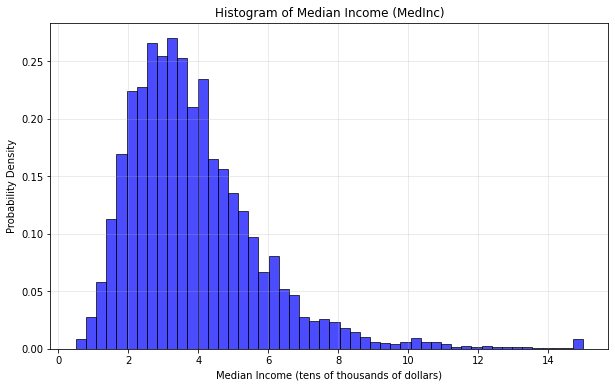

In [3]:
plt.figure(figsize=(10, 6))
plt.hist(df['MedInc'], bins=50, density=True, alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram of Median Income (MedInc)')
plt.xlabel('Median Income (tens of thousands of dollars)')
plt.ylabel('Probability Density')
plt.grid(True, alpha=0.3)

In [4]:
# fitting potential distributions
x = np.linspace(df['MedInc'].min(), df['MedInc'].max(), 1000)

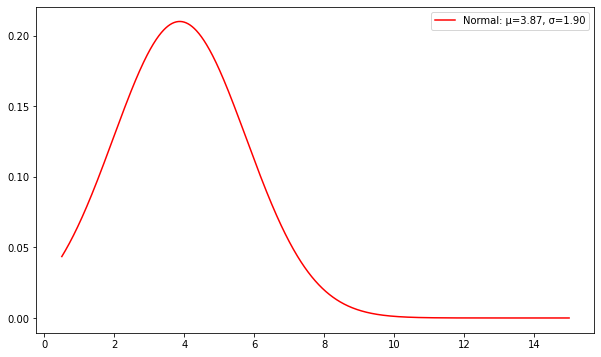

In [5]:
# normal distribution
mu, sigma = stats.norm.fit(df['MedInc'])
pdf_norm = stats.norm.pdf(x, mu, sigma)

plt.figure(figsize=(10, 6))
plt.plot(x, pdf_norm, 'r-', label=f'Normal: μ={mu:.2f}, σ={sigma:.2f}')
plt.legend()
plt.show();

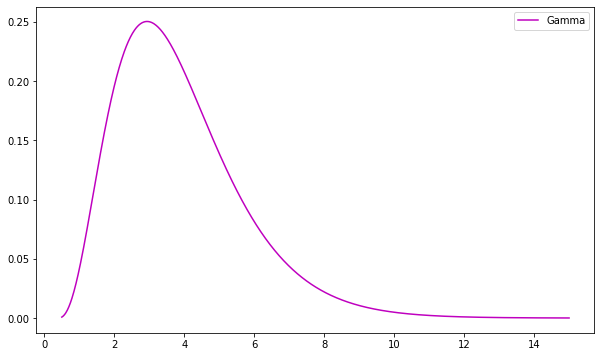

In [6]:
# gamma distribution
a, loc, scale = stats.gamma.fit(df['MedInc'])
pdf_gamma = stats.gamma.pdf(x, a, loc, scale)

plt.figure(figsize=(10, 6))
plt.plot(x, pdf_gamma, 'm-', label=f'Gamma')
plt.legend()
plt.show();

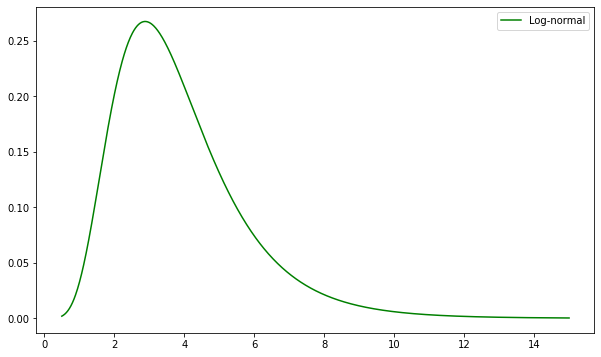

In [7]:
# log-normal distribution
shape, loc, scale = stats.lognorm.fit(df['MedInc'])
pdf_lognorm = stats.lognorm.pdf(x, shape, loc, scale)

plt.figure(figsize=(10, 6))
plt.plot(x, pdf_lognorm, 'g-', label=f'Log-normal')
plt.legend()
plt.show();

Log-normal distribution fits our data the best!

### Task 2

Besides the log-normal distribution, the `gamma distribution` is also a good fit here.  
Let's find the parameters of the distribution for our sample.  
It has three main parameters:
- loc (we will assume it to be 0),
- a (we will search for it),
- scale (we will search for it as well).

To do this, first implement a function that will calculate the log-likelihood for our sample.  
Next, use the `minimize` function from the `optimize` module of the scipy library.  
Use `a=1`, `scale=2` as the initial approximation.  

Draw on one graph the histogram of your random variable and the probability density function (PDF) with the tuned parameters.   

What parameter values did you obtain?

In [8]:
from scipy.optimize import minimize

In [9]:
medinc = df['MedInc']

In [10]:
# defining the negative log-likelihood function for gamma distribution
def neg_log_likelihood(params):
    a, scale = params
    # return a very large value if parameters are invalid
    if a <= 0 or scale <= 0:
        return 1e10
    # calculate the log-likelihood (sum of log-pdf values)
    log_likelihood = np.sum(stats.gamma.logpdf(medinc, a=a, scale=scale, loc=0))
    # return negative log-likelihood (because we're minimizing)
    return -log_likelihood

In [11]:
# initial parameter values as specified # a=1, scale=2
initial_params = [1, 2]  

# minimizing the negative log-likelihood using L-BFGS-B method
result = minimize(neg_log_likelihood, 
                  initial_params, 
                  method='L-BFGS-B',
                  bounds=[(1e-10, None), (1e-10, None)]) 

# extracting the optimized parameters
a_opt, scale_opt = result.x

In [12]:
# creating x values for plotting the PDF
x = np.linspace(medinc.min(), medinc.max(), 1000)

# calculating the gamma PDF with optimized parameters
gamma_pdf = stats.gamma.pdf(x, a=a_opt, scale=scale_opt, loc=0)

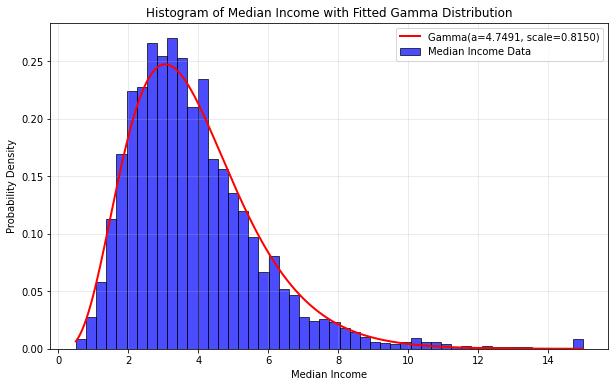

Optimal parameters: a = 4.7491, scale = 0.8150


In [13]:
plt.figure(figsize=(10, 6))
plt.hist(medinc, bins=50, density=True, alpha=0.7, color='blue', 
         edgecolor='black', label='Median Income Data')
plt.plot(x, gamma_pdf, 'r-', linewidth=2, 
         label=f'Gamma(a={a_opt:.4f}, scale={scale_opt:.4f})')
plt.title('Histogram of Median Income with Fitted Gamma Distribution')
plt.xlabel('Median Income')
plt.ylabel('Probability Density')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print(f'Optimal parameters: a = {a_opt:.4f}, scale = {scale_opt:.4f}')

### Task 3

Calculate the `kernel density estimate` at the point `x=6` for the median income using `sklearn.neighbors.KernelDensity` with a triangular (linear) kernel and `h=0.5`.  
Note that you will receive the logarithms of the estimate, so you need to take the exponent of them.

In [14]:
from sklearn.neighbors import KernelDensity

In [15]:
medinc = df['MedInc'].values.reshape(-1, 1)

In [16]:
kde = KernelDensity(bandwidth=0.5, kernel='linear')
kde.fit(medinc)

KernelDensity(bandwidth=0.5, kernel='linear')

In [17]:
# calculating the log density at x=6
x_point = np.array([[6.0]])
log_density = kde.score_samples(x_point)

In [18]:
# converting from log density to density by taking exponent
density = np.exp(log_density)

print(f'KDE density estimate at x=6 with triangular kernel and h=0.5: {density[0]:.4f}')

KDE density estimate at x=6 with triangular kernel and h=0.5: 0.0739


### Task 4

Let's check if the value calculated using this formula is indeed a probability density.  

To do this, take the density estimate configured in the previous task and verify that the area under the curve of the density estimate graph **equals one**. This is the condition for a function to qualify as a density (similar to how the sum of probabilities of all possible outcomes must equal one).  

In [19]:
medinc = df['MedInc'].values.reshape(-1, 1)

In [20]:
kde = KernelDensity(bandwidth=0.5, kernel='linear')
kde.fit(medinc)

KernelDensity(bandwidth=0.5, kernel='linear')

In [21]:
# determining the bounds for integration (adding margin to min and max values)
min_val = float(medinc.min()) - 1  # 1 unit to the left of min
max_val = float(medinc.max()) + 1  # 1 unit to the right of max

print(f'Data range: {float(medinc.min()):.2f} to {float(medinc.max()):.2f}')
print(f'Integration range: {min_val:.2f} to {max_val:.2f}')

Data range: 0.50 to 15.00
Integration range: -0.50 to 16.00


In [22]:
for num_points in [100, 1000, 10000, 100000]:
    # generating grid of points
    x_grid = np.linspace(min_val, max_val, num_points).reshape(-1, 1)
    
    # calculating KDE at each point
    log_density = kde.score_samples(x_grid)
    density = np.exp(log_density)
    
    # calculating width of each rectangle
    width = (max_val - min_val) / (num_points - 1)
    
    # calculating area using rectangle method (Riemann sum)
    area = np.sum(density * width)
    
    print(f'Number of points: {num_points}, Area under KDE curve: {area:.4f}')


Number of points: 100, Area under KDE curve: 1.0000
Number of points: 1000, Area under KDE curve: 1.0000
Number of points: 10000, Area under KDE curve: 1.0000
Number of points: 100000, Area under KDE curve: 1.0000


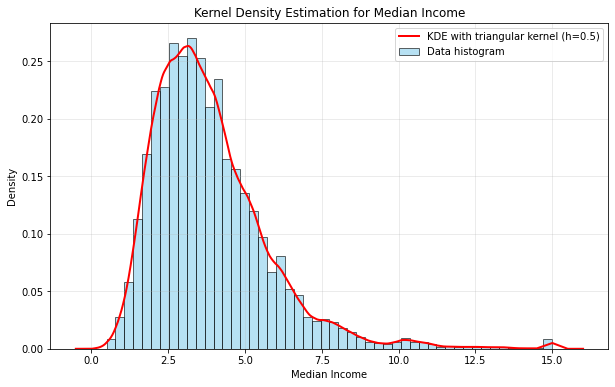

In [23]:
# visualizing initial data
plt.figure(figsize=(10, 6))
plt.hist(medinc, bins=50, density=True, alpha=0.6, color='skyblue', 
         edgecolor='black', label='Data histogram')

# visualizing kde
x_grid = np.linspace(min_val, max_val, 1000).reshape(-1, 1)
log_density = kde.score_samples(x_grid)
density = np.exp(log_density)

plt.plot(x_grid, density, 'r-', linewidth=2, 
         label='KDE with triangular kernel (h=0.5)')
plt.title('Kernel Density Estimation for Median Income')
plt.xlabel('Median Income')
plt.ylabel('Density')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()